In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import tensorflow as tf
import zipfile
import pathlib
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = "/content/blackandwhite.zip"
extracted_dir_path = "/content/image"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [ ]:
data_dir = pathlib.Path("/content/images/blackandwhite")
data_dir = pathlib.Path(data_dir).with_suffix('')

In [ ]:
file_list = os.listdir(data_dir)
print(file_list)

['pants', 'shorts', 'socks', 'tshirts', 'dresses', 'skirts', 'underwear', 'shoes', '.DS_Store', 'shirts', 'outerwear']


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

495


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = '/content/photos/blackandwhite/dresses/Dresses1.jpeg'  # Replace this with the actual path to an image
try:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes for clarity
    plt.show()  # Display the image using Matplotlib
except Exception as e:
    print(f"Error opening image: {e}")

Error opening image: [Errno 2] No such file or directory: '/content/photos/blackandwhite/dresses/Dresses1.jpeg'


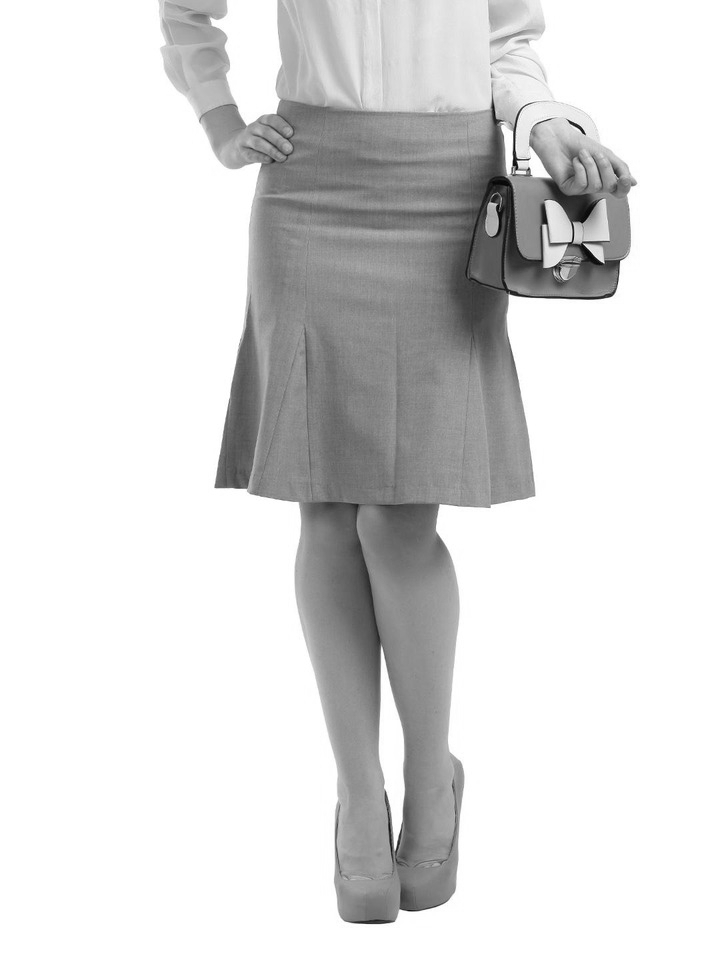

In [ ]:
skirts = list(data_dir.glob('skirts/*'))
PIL.Image.open(str(skirts[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 495 files belonging to 10 classes.
Using 396 files for training.
Found 495 files belonging to 10 classes.
Using 99 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['dresses', 'outerwear', 'pants', 'shirts', 'shoes', 'shorts', 'skirts', 'socks', 'tshirts', 'underwear']


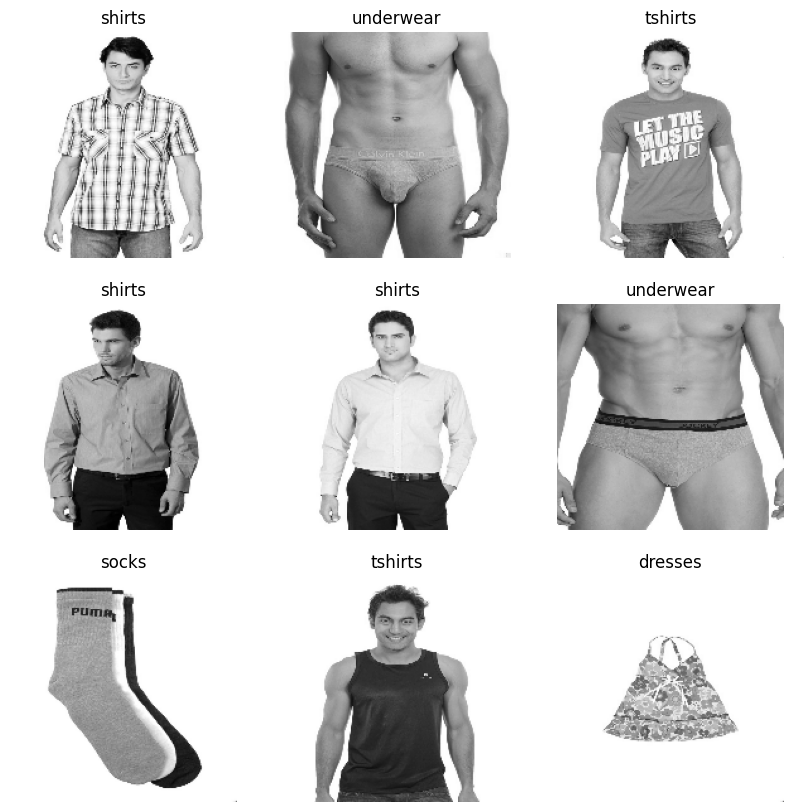

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.038235296 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
epochs= 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 15s 1s/step - loss: 2.2922 - accuracy: 0.1843 - val_loss: 2.0395 - val_accuracy: 0.3939
Epoch 2/10
13/13 [==============================] - 14s 1s/step - loss: 1.3693 - accuracy: 0.5783 - val_loss: 1.2013 - val_accuracy: 0.5455
Epoch 3/10
13/13 [==============================] - 14s 1s/step - loss: 0.7828 - accuracy: 0.7298 - val_loss: 1.0646 - val_accuracy: 0.6465
Epoch 4/10
13/13 [==============================] - 13s 989ms/step - loss: 0.5944 - accuracy: 0.8157 - val_loss: 0.7403 - val_accuracy: 0.7677
Epoch 5/10
13/13 [==============================] - 14s 1s/step - loss: 0.3647 - accuracy: 0.8788 - val_loss: 0.9323 - val_accuracy: 0.6869
Epoch 6/10
13/13 [==============================] - 14s 1s/step - loss: 0.2940 - accuracy: 0.9015 - val_loss: 0.8259 - val_accuracy: 0.7576
Epoch 7/10
13/13 [==============================] - 14s 1s/step - loss: 0.2548 - accuracy: 0.9268 - val_loss: 1.0224 - val_accuracy: 0.7475
Epoch 8/10
13/13 

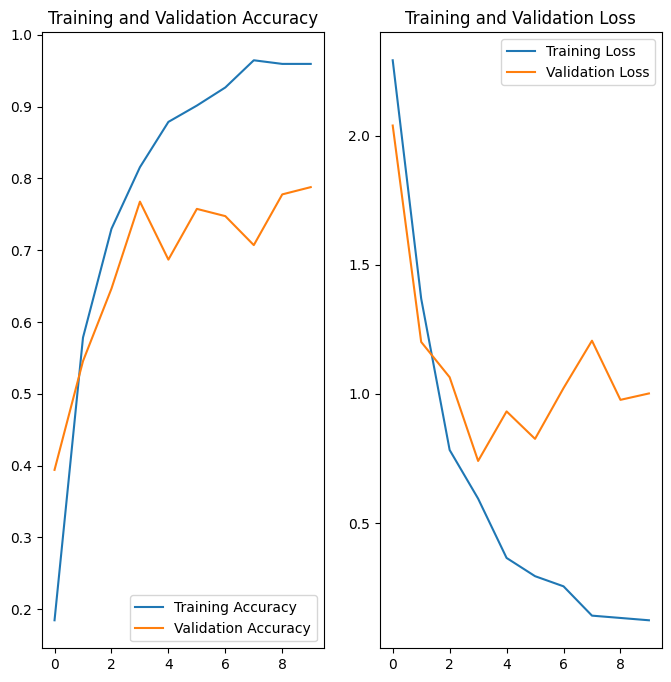

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
shirt = "/content/shirtgs.png"
img = tf.keras.utils.load_img(
    shirt, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
jean = "/content/jeangs.png"
img = tf.keras.utils.load_img(
    jean, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
jacket = "/content/jacketgs.png"
img = tf.keras.utils.load_img(
    jacket, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 97ms/step
This image most likely belongs to socks with a 70.68 percent confidence.
1/1 [==============================] - 0s 32ms/step
This image most likely belongs to pants with a 48.91 percent confidence.
1/1 [==============================] - 0s 34ms/step
This image most likely belongs to tshirts with a 85.02 percent confidence.


In [ ]:
test1 = "/content/testgs1.jpg"
img = tf.keras.utils.load_img(
    test1, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
test2 = "/content/testgc2.jpg"
img = tf.keras.utils.load_img(
    test2, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
test3 = "/content/testgs3.jpg"
img = tf.keras.utils.load_img(
    test3, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
test4 = "/content/testgs4.jpg"
img = tf.keras.utils.load_img(
    test4, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
test5 = "/content/testgs5.jpeg"
img = tf.keras.utils.load_img(
    test5, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
test6 = "/content/testgs6.jpg"
img = tf.keras.utils.load_img(
    test6, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 30ms/step
This image most likely belongs to tshirts with a 81.67 percent confidence.
1/1 [==============================] - 0s 31ms/step
This image most likely belongs to shirts with a 34.37 percent confidence.
1/1 [==============================] - 0s 30ms/step
This image most likely belongs to shorts with a 82.94 percent confidence.
1/1 [==============================] - 0s 29ms/step
This image most likely belongs to skirts with a 98.90 percent confidence.
1/1 [==============================] - 0s 30ms/step
This image most likely belongs to underwear with a 58.98 percent confidence.
1/1 [==============================] - 0s 37ms/step
This image most likely belongs to underwear with a 99.95 percent confidence.
